In [1]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip as gz
import scipy
from importlib import reload
import glob
import tqdm
import itertools
from scipy.spatial.distance import cdist
import scanpy as sc

import sys
sys.path.append('/Genomics/pritykinlab/dillon/perturbseq/scripts/utils')
import dataloader
import umap_analysis
import reimplementation
import normalization
import adata_utils
from scipy.stats import mannwhitneyu

In [2]:
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.markersize"] = 5
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.edgecolor'] = 'dimgray'
plt.rcParams['figure.figsize'] = (7,7)

# Loading the data

In [3]:
adata = sc.read_h5ad("/Genomics/pritykinlab/yujie/preprocessing_benchmarking/datasets/breast_cancer/qian/patient_specific_data/patient_50_adata.h5ad")
adata.var.index = adata.var.index.map(lambda e: e.split('\t')[0])

# Panel e-f

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

def default_pipeline(adata, num_hvg, celltype_colors=None):
    num_pcs = 20
    print(f"############################ num_pcs: {num_pcs}; num_hvg: {num_hvg} ############################")
    adata = adata.copy()
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=5)
    print("num_cells: {}, num_genes: {}".format(adata.shape[0], adata.shape[1]))
    sc.pp.normalize_total(adata)
    adata.layers['raw_norm'] = adata.X.copy()
    sc.pp.log1p(adata)
    if num_hvg != None:
        sc.pp.highly_variable_genes(adata, n_top_genes=num_hvg, flavor='seurat')
        adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=num_pcs)
    sc.pp.neighbors(adata, n_pcs=num_pcs)  # Use the same number of PCs for neighbors
    sc.tl.umap(adata)

    # Define colors for the cell types
    if celltype_colors:
        sc.pl.umap(adata, color='CellType', legend_loc='on data', frameon=False, palette=celltype_colors)
    else:
        sc.pl.umap(adata, color='CellType', legend_loc='on data', frameon=False)


    sc.tl.leiden(adata, resolution=3)
    adata.obs['leiden_3'] = adata.obs['leiden']
    return adata

# Example usage
celltype_colors = {
    'B_cell': '#FFD700',
    'DC': 'green',
    'EC': 'brown',
    'Fibroblast': 'purple',
    'T_cell': 'red',
    'Cancer': '#FF9999',  # Pastel red
    'Myeloid': '#99CCFF'  # Pastel blue
}

adata_2000 = default_pipeline(adata, 2000, celltype_colors)
adata_4000 = default_pipeline(adata, 4000, celltype_colors)
adata_8000 = default_pipeline(adata, 8000, celltype_colors)

/Genomics/argo/users/yq7946/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


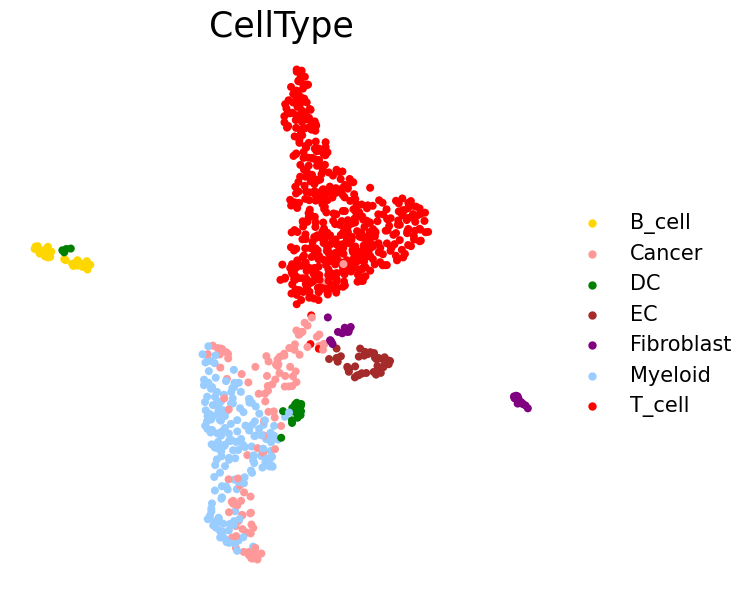

/Genomics/argo/users/yq7946/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


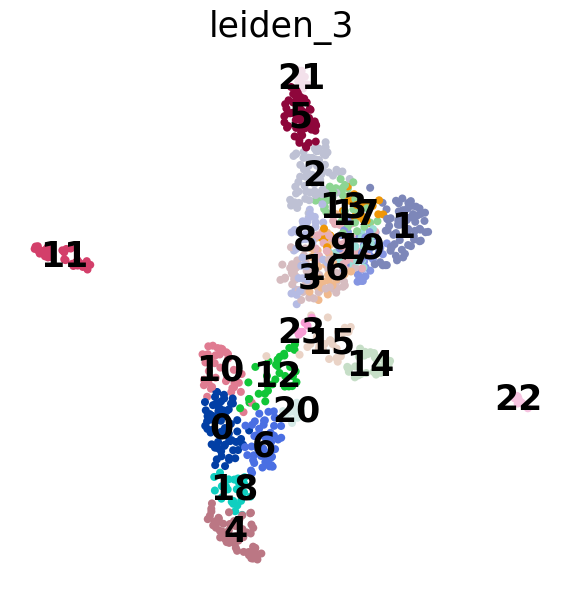

In [44]:
# this is for HVG=2000
sc.pl.umap(adata_2000, color=['CellType'], frameon=False, palette=celltype_colors)
sc.pl.umap(adata_2000, color=['leiden_3'], legend_loc='on data', frameon=False, legend_fontsize='25')

/Genomics/argo/users/yq7946/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


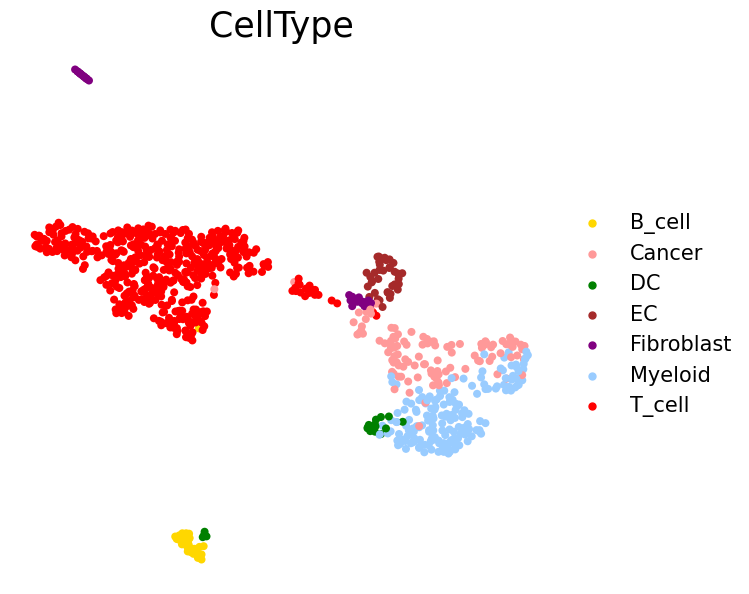

/Genomics/argo/users/yq7946/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


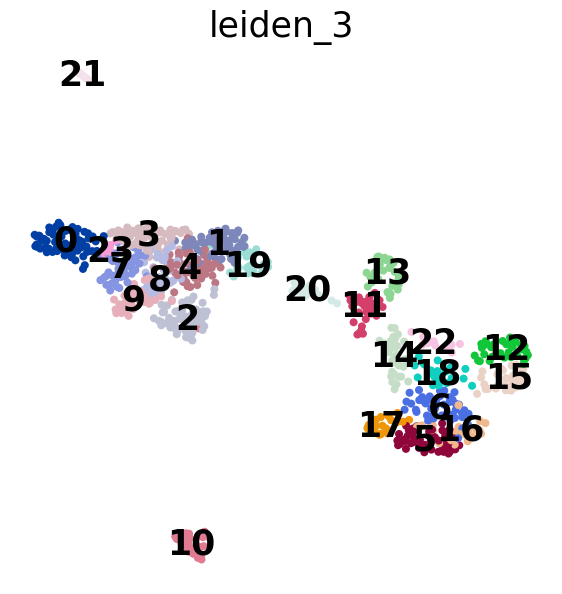

In [45]:
# this is for HVG=8000
sc.pl.umap(adata_8000, color=['CellType'], frameon=False, palette=celltype_colors)
sc.pl.umap(adata_8000, color=['leiden_3'], legend_loc='on data', frameon=False, legend_fontsize='25')

# Panel g

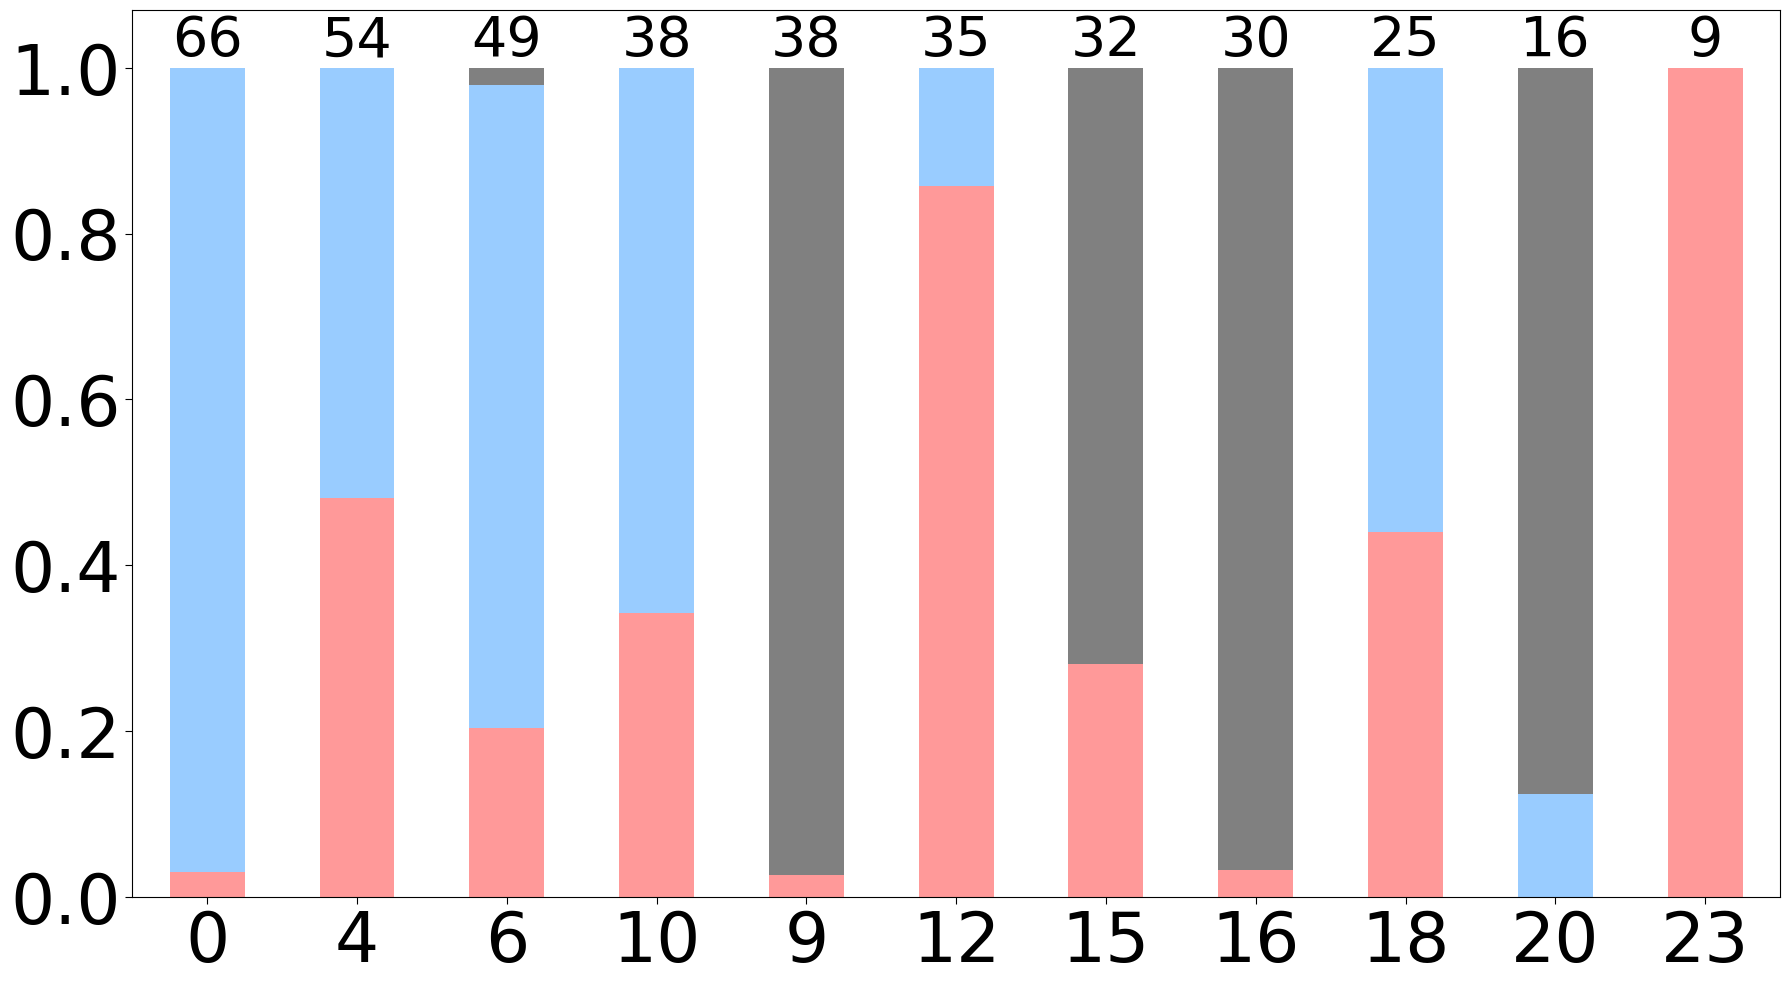

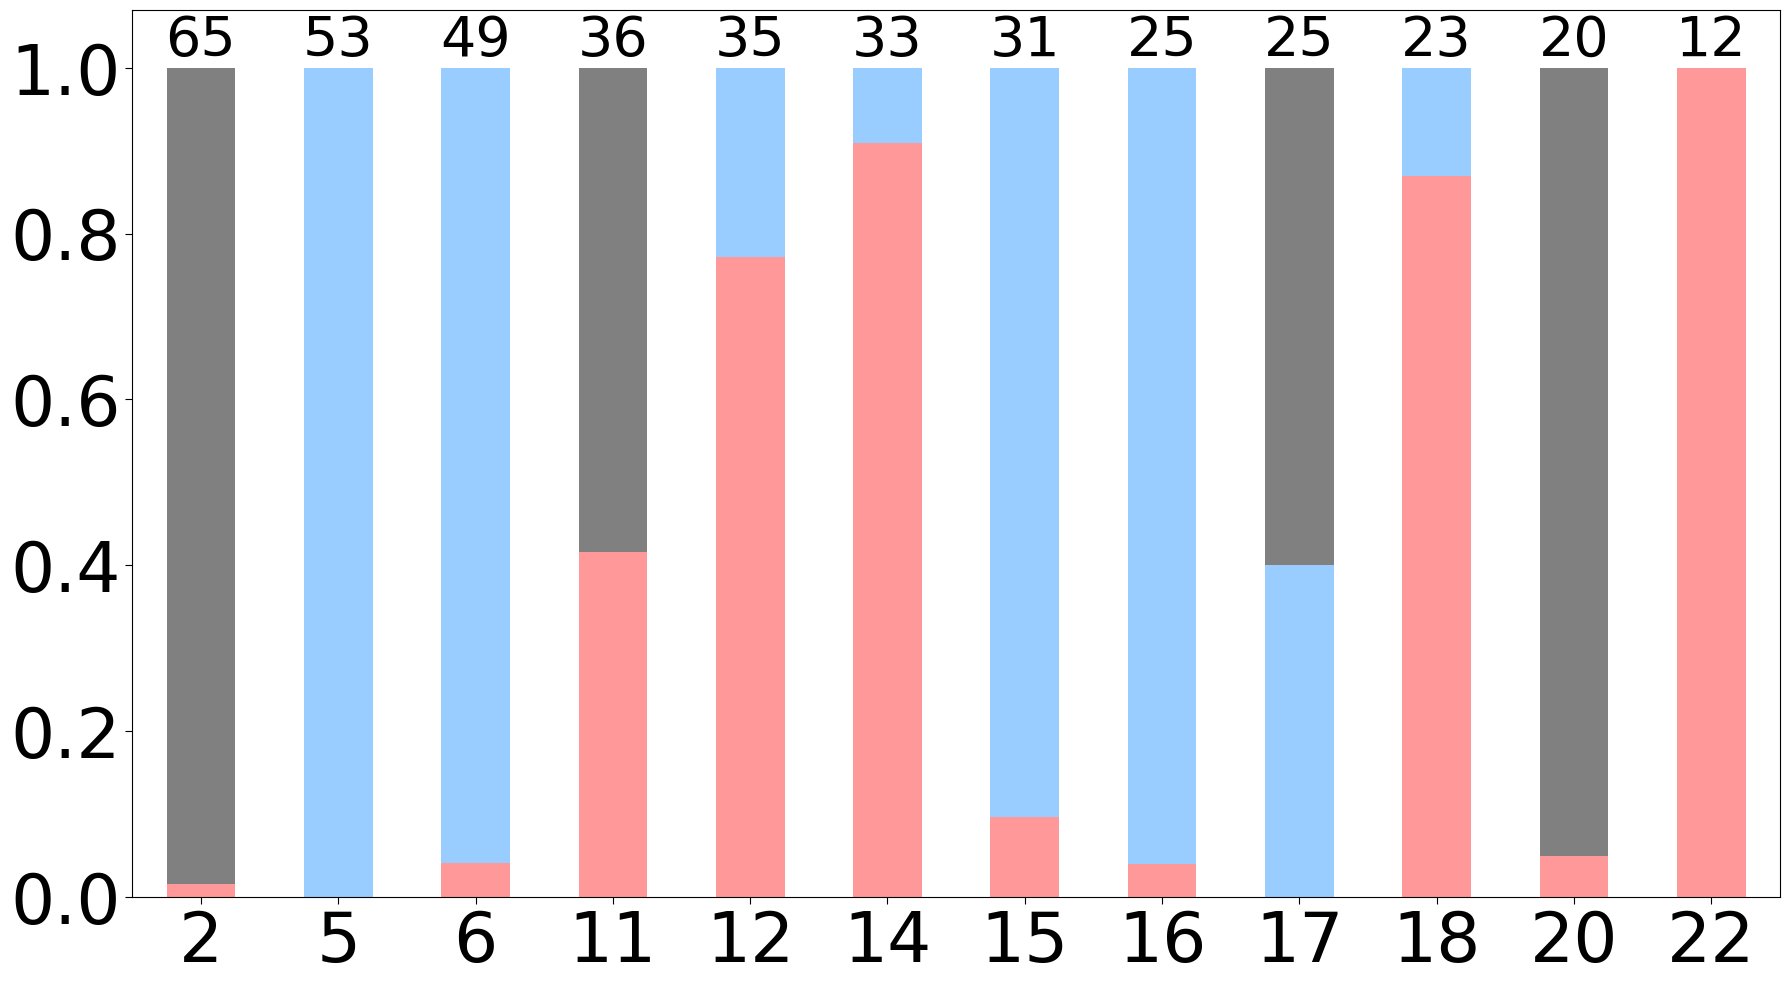

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot cell type proportions within specific Leiden clusters with custom colors
def plot_celltype_proportions(adata):
    # Convert relevant data to a pandas DataFrame
    df = pd.DataFrame({
        'leiden_cluster': adata.obs['leiden_3'].astype(str),  # Ensure leiden_cluster is treated as string
        'cell_type': adata.obs['CellType']
    })

    # Group all cell types not in custom_colors as 'Other'
    custom_colors = {
        'Cancer': '#FF9999',  # Pastel red
        'Myeloid': '#99CCFF'  # Pastel blue
    }
    df['cell_type'] = df['cell_type'].apply(lambda x: x if x in custom_colors else 'Other')

    # Filter clusters that contain at least one 'Cancer' or 'Myeloid' cell
    clusters_with_cancer_or_myeloid = df[df['cell_type'].isin(['Cancer', 'Myeloid'])]['leiden_cluster'].unique()
    filtered_df = df[df['leiden_cluster'].isin(clusters_with_cancer_or_myeloid)]

    # Get counts of each cell type for each Leiden cluster
    counts = filtered_df.groupby(['leiden_cluster', 'cell_type']).size().unstack(fill_value=0)

    # Sort clusters by size
    cluster_sizes = counts.sum(axis=1).sort_values(ascending=False)
    counts = counts.loc[cluster_sizes.index]

    # Normalize the counts to get proportions
    proportions = counts.divide(counts.sum(axis=1), axis=0)

    # Update custom colors to include 'Other'
    custom_colors['Other'] = 'grey'

    # Generate a color list for all cell types
    color_list = [custom_colors[cell_type] for cell_type in proportions.columns]

    # Plot stacked bar chart
    ax = proportions.plot(kind='bar', stacked=True, figsize=(18, 10), color=color_list, legend=False)

    # Rotate x-axis tick labels to vertical
    plt.ylim(0, 1.07)
    ax.set_xticks(range(len(proportions.index)))
    ax.set_xticklabels(proportions.index, rotation=360, ha='center', fontsize=50)
    plt.yticks(fontsize=50)
    
    # Add the number of cells per cluster on top of each bar
    for i, (cluster, row) in enumerate(counts.iterrows()):
        total_cells = row.sum()
        ax.text(i, 1, f'{total_cells}', ha='center', va='bottom', fontsize=40)

    # Add labels
    plt.xlabel('')
    plt.ylabel('')

    # Adjust the plot area to fit the legend and prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with the specific Leiden clusters
plot_celltype_proportions(adata_2000)
plot_celltype_proportions(adata_8000)


# Panel h

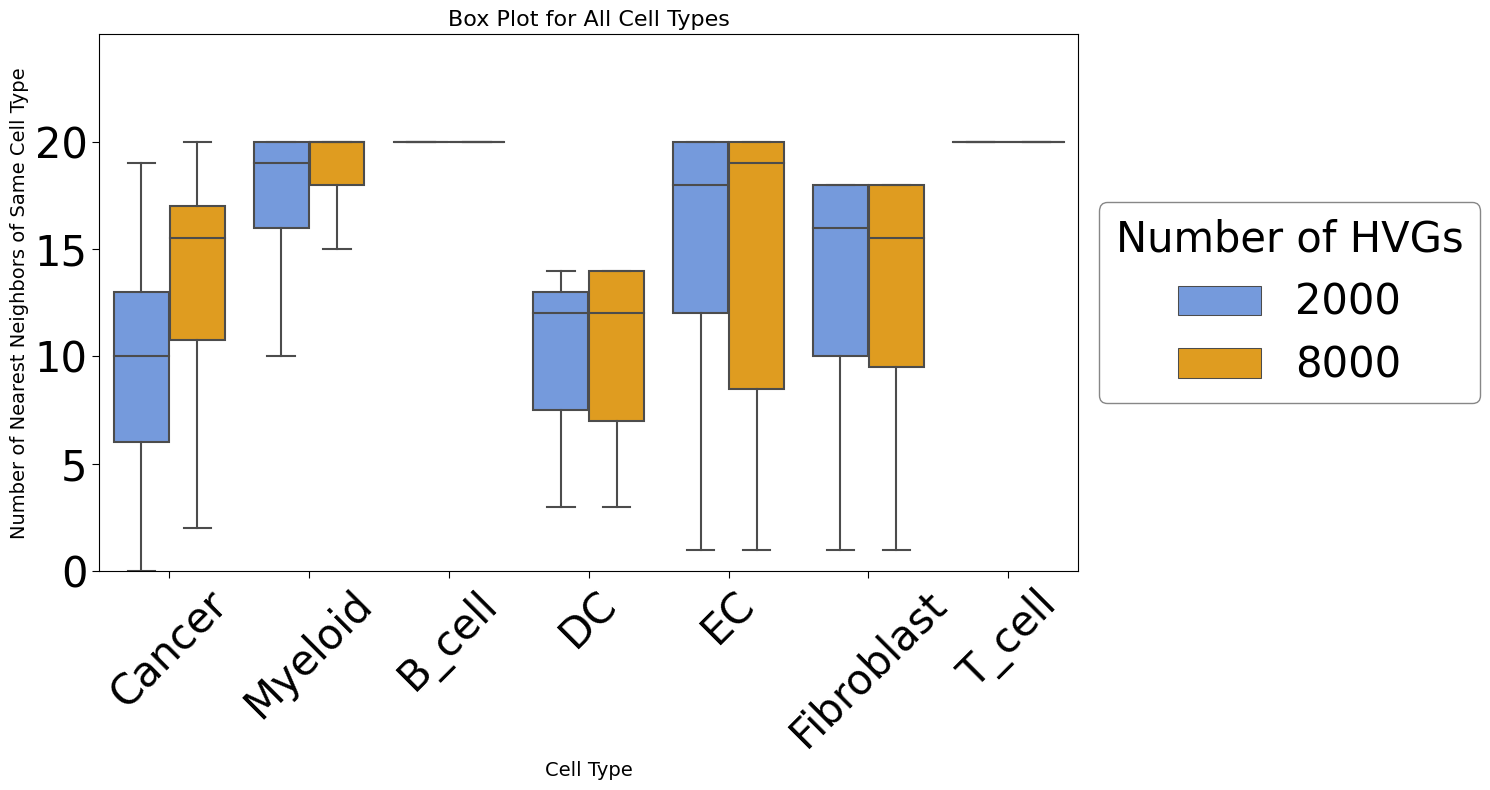

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_box(data):
    """
    Generates a box plot for all cell types, grouped by the number of HVGs using hue.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the data to plot.
    """
    # Define custom colors for hue
    color_palette = {
        2000: 'cornflowerblue',
        8000: 'orange'
    }
    
    # Sort the data for custom ordering
    order = ['Cancer', 'Myeloid'] + [ct for ct in sorted(data['label'].unique()) if ct not in ['Cancer', 'Myeloid']]
    data['label'] = pd.Categorical(data['label'], categories=order, ordered=True)
    data = data.sort_values('label')

    plt.figure(figsize=(15, 8))
    sns.boxplot(x='label', y='num_NN_same_cell_type', hue='num_hvg', data=data, palette=color_palette, fliersize=0)
    plt.ylim(0, 25)
    plt.yticks(range(0, 21, 5), fontsize=30)  # Set y-axis to discrete values with steps of 5 and adjust font size
    plt.xticks(rotation=45, fontsize=30)  # Rotate x-axis labels for better readability
    plt.gca().set_xlabel('Cell Type', fontsize=14)
    plt.gca().set_ylabel('Number of Nearest Neighbors of Same Cell Type', fontsize=14)
    plt.title('Box Plot for All Cell Types', fontsize=16)
    plt.legend(title='Number of HVGs', fontsize=30, title_fontsize=30, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()  # Adjust layout to fit everything nicely
    plt.show()

# Load the data
results_df = pd.read_csv("/Genomics/pritykinlab/dillon/preprocessing_benchmarking/results/pilot/atlas_sample_qian/aggregated_results.tsv", sep='\t')
results_df['num_NN_same_cell_type'] = 20 - results_df['avg_KNN_dissimilarity']*20
results_df = results_df[results_df['num_hvg'].isin([2000, 8000])]

# Run the function
plot_box(results_df)


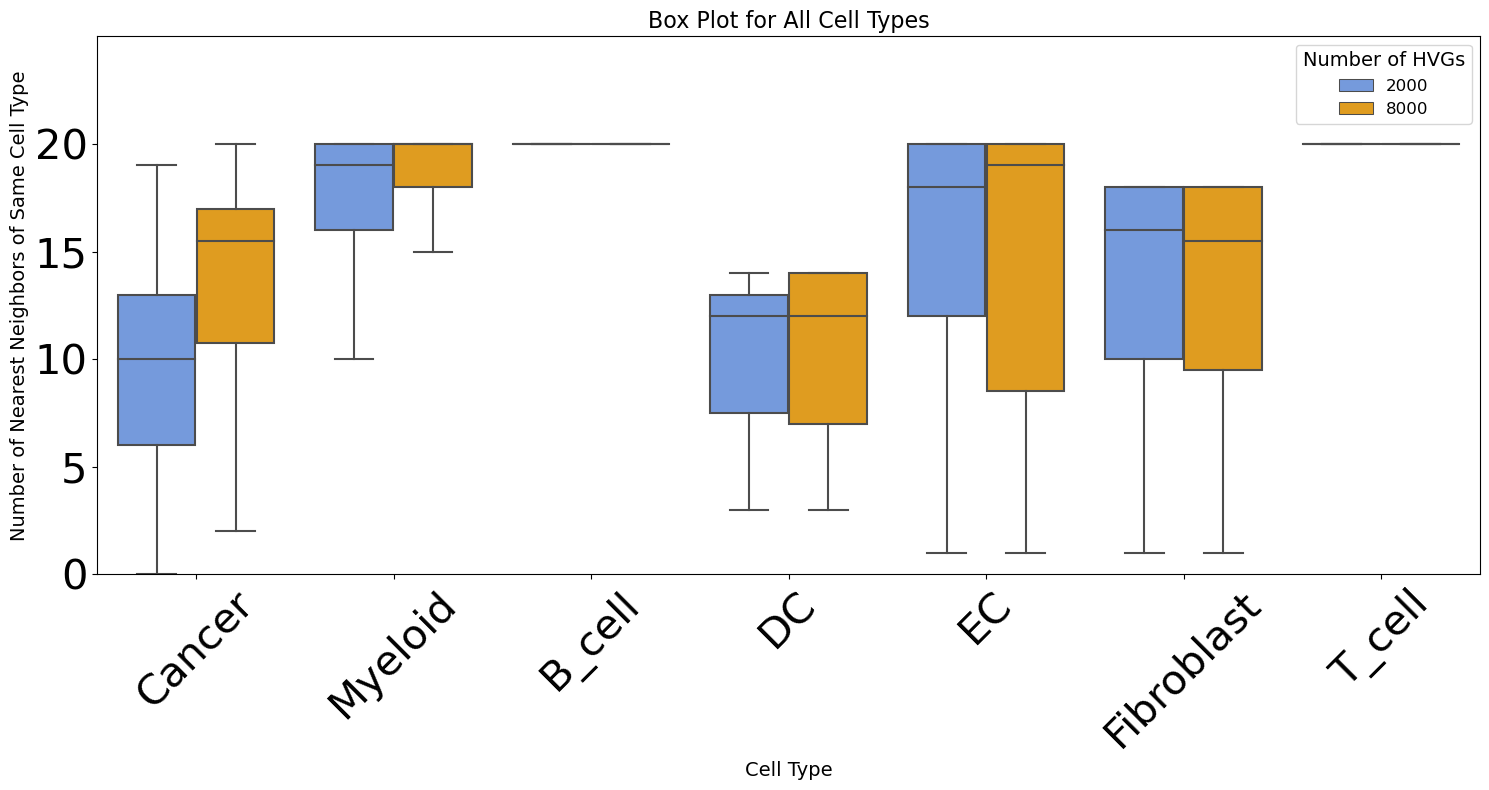

    Cell Type       p-value
0      T_cell  2.071403e-01
1      Cancer  1.301490e-08
2          EC  9.362794e-01
3     Myeloid  3.804137e-03
4  Fibroblast  8.377007e-01
5      B_cell  8.424355e-01
6          DC  5.790997e-01


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ranksums

def plot_box(data):
    """
    Generates a box plot for all cell types, grouped by the number of HVGs using hue.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the data to plot.
    """
    # Define custom colors for hue
    color_palette = {
        2000: 'cornflowerblue',
        8000: 'orange'
    }
    
    # Sort the data for custom ordering
    order = ['Cancer', 'Myeloid'] + [ct for ct in sorted(data['label'].unique()) if ct not in ['Cancer', 'Myeloid']]
    data['label'] = pd.Categorical(data['label'], categories=order, ordered=True)
    data = data.sort_values('label')

    plt.figure(figsize=(15, 8))
    sns.boxplot(x='label', y='num_NN_same_cell_type', hue='num_hvg', data=data, palette=color_palette, fliersize=0)
    plt.ylim(0, 25)
    plt.yticks(range(0, 21, 5), fontsize=30)  # Set y-axis to discrete values with steps of 5 and adjust font size
    plt.xticks(rotation=45, fontsize=30)  # Rotate x-axis labels for better readability
    plt.gca().set_xlabel('Cell Type', fontsize=14)
    plt.gca().set_ylabel('Number of Nearest Neighbors of Same Cell Type', fontsize=14)
    plt.title('Box Plot for All Cell Types', fontsize=16)
    plt.legend(title='Number of HVGs', fontsize=12, title_fontsize=14)
    plt.tight_layout()  # Adjust layout to fit everything nicely
    plt.show()

def run_rank_sum_test(data):
    """
    Runs rank sum test for each cell type between 2000 and 8000 HVGs.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the data to test.
    
    Returns:
    pd.DataFrame: DataFrame containing cell types and their p-values.
    """
    p_values = []
    cell_types = data['label'].unique()
    
    for cell_type in cell_types:
        group_2000 = data[(data['label'] == cell_type) & (data['num_hvg'] == 2000)]['num_NN_same_cell_type']
        group_8000 = data[(data['label'] == cell_type) & (data['num_hvg'] == 8000)]['num_NN_same_cell_type']
        
        if len(group_2000) > 0 and len(group_8000) > 0:
            stat, p_value = ranksums(group_2000, group_8000)
            p_values.append((cell_type, p_value))
    
    p_values_df = pd.DataFrame(p_values, columns=['Cell Type', 'p-value'])
    return p_values_df

# Load the data
results_df = pd.read_csv("/Genomics/pritykinlab/dillon/preprocessing_benchmarking/results/pilot/atlas_sample_qian/aggregated_results.tsv", sep='\t')
results_df['num_NN_same_cell_type'] = 20 - results_df['avg_KNN_dissimilarity']*20
results_df = results_df[results_df['num_hvg'].isin([2000, 8000])]

# Run the function
plot_box(results_df)

# Run rank sum test
p_values_df = run_rank_sum_test(results_df)
print(p_values_df)
